* subjectivity score
* length of tweets -- CHECK
* do longer tweets tend to be more positive or negative --  CHECK
* word clouds
* add random state in train test split -- CHECK
* ensemble method -- CHECK
* cross validation -- CHECK

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [103]:
import nltk
from nltk.corpus import stopwords
from nltk.collections import *
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
import string
import re

In [210]:
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [306]:
df = pd.read_csv('tweet_product_company.csv', engine = 'python')

## Data Understanding

In [307]:
df.shape

(9093, 3)

In [10]:
df.head()

,text,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     9092 non-null   object
 1   product  3291 non-null   object
 2   emotion  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [16]:
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [17]:
df['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [310]:
gb = df.groupby('product')['emotion'].value_counts()
gb

product                          emotion                           
Android                          Positive emotion                       69
                                 Negative emotion                        8
                                 No emotion toward brand or product      1
Android App                      Positive emotion                       72
                                 Negative emotion                        8
                                 No emotion toward brand or product      1
Apple                            Positive emotion                      543
                                 Negative emotion                       95
                                 No emotion toward brand or product     21
                                 I can't tell                            2
Google                           Positive emotion                      346
                                 Negative emotion                       68
                                

<AxesSubplot:title={'center':'Tweet Emotion Frequency by Product'}, xlabel='Product/Company', ylabel='Frequency'>

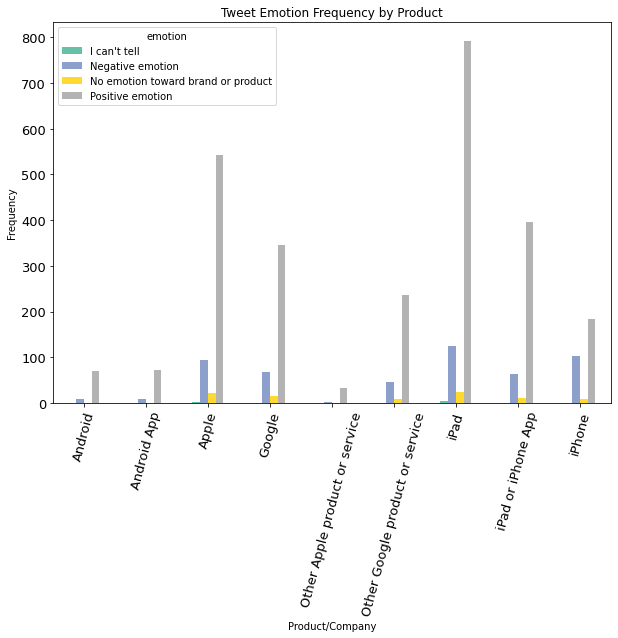

In [311]:
gb.unstack(level=1).plot(kind='bar', 
                         figsize = (10,7), 
                         fontsize = 13, 
                         rot = 75,
                         ylabel = 'Frequency',
                         xlabel = 'Product/Company',
                         title = 'Tweet Emotion Frequency by Product',
                         colormap = 'Set2'
                        )

## Data Cleaning

In [313]:
df.rename(columns = {'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 
                     'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace = True)

In [314]:
# Dropping rows with 'I can't tell' as emotion

# df = df[df['emotion'] != "I can't tell"]
# df['emotion'] = np.where(df['emotion'] == "I can't tell", 'No emotion toward brand or product', df['emotion'])

In [315]:
# Converting 'text' column to str dtype

df['text'] = df['text'].astype(str)

In [316]:
# Tokenize

pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

df['tokens'] = df['text'].apply(lambda x: nltk.regexp_tokenize(x, pattern))

In [317]:
# Make sure tokens are lowercase

df['tokens'] = df['tokens'].apply(lambda x: [i.lower() for i in x])

In [318]:
# Create Stopwords list

stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += list(range(0,10))   

In [319]:
# Filter for stopwords

df['tokens'] = df['tokens'].apply(lambda x: [i for i in x if i not in stopwords_list ])

## Feature Engineering

In [ ]:
# Create new column indicating whether tweet is about apple or google

df['split_products'] = df['product'].apply(lambda x: x.split(' ') if type(x) != float else ['nan'])

ag_list = []
for i in range(len(df['split_products'])):
    if any(x in ['Google', 'Android'] for x in df['split_products'][i]):
        ag_list.append('google')
    elif any(x in ['Apple', 'iPad', 'iPhone'] for x in df['split_products'][i]):
        ag_list.append('apple')
    else:
        ag_list.append('neither')
ag_list
df['a_or_g'] = ag_list

In [142]:
ag_gb = df.groupby('a_or_g')['emotion'].value_counts()
ag_gb

a_or_g   emotion                           
apple    Positive emotion                      1949
         Negative emotion                       388
         No emotion toward brand or product      65
         I can't tell                             7
google   Positive emotion                       723
         Negative emotion                       131
         No emotion toward brand or product      26
         I can't tell                             2
neither  No emotion toward brand or product    5298
         Positive emotion                       306
         I can't tell                           147
         Negative emotion                        51
Name: emotion, dtype: int64

In [320]:
# Create new column indicating whether tweet is about apple or google
# Column sourced from tokens column. Original 'product' column unreliable

ag_list2 = []
for i in range(len(df['tokens'])):
    if any(x in ['google', 'android'] for x in df['tokens'][i]):
        ag_list2.append('google')
    elif any(x in ['apple', 'ipad', 'iphone'] for x in df['tokens'][i]):
        ag_list2.append('apple')
    else:
        ag_list2.append('neither')
ag_list2
df['a_or_g2'] = ag_list2

In [321]:
ag_gb = df.groupby('a_or_g2')['emotion'].value_counts()
ag_gb

a_or_g2  emotion                           
apple    No emotion toward brand or product    2689
         Positive emotion                      2038
         Negative emotion                       401
         I can't tell                            92
google   No emotion toward brand or product    1815
         Positive emotion                       828
         Negative emotion                       156
         I can't tell                            53
neither  No emotion toward brand or product     885
         Positive emotion                       112
         Negative emotion                        13
         I can't tell                            11
Name: emotion, dtype: int64

In [94]:
df['a_or_g'].value_counts()

neither    5802
apple      2409
google      882
Name: a_or_g, dtype: int64

In [100]:
df['a_or_g2'].value_counts()

apple      5220
google     2852
neither    1021
Name: a_or_g2, dtype: int64

In [325]:
df['tokens_linked']=[" ".join(token) for token in df['tokens'].values]

In [326]:
df['raw_text_len'] = df['text'].apply(len)

In [327]:
df['tokens_linked_len'] = df['tokens_linked'].apply(len)

In [328]:
df['tokens_list_len'] = df['tokens'].apply(len)

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
#

## EDA 2

<AxesSubplot:title={'center':'Tweet Emotion Frequency by Company'}, xlabel='Company', ylabel='Frequency'>

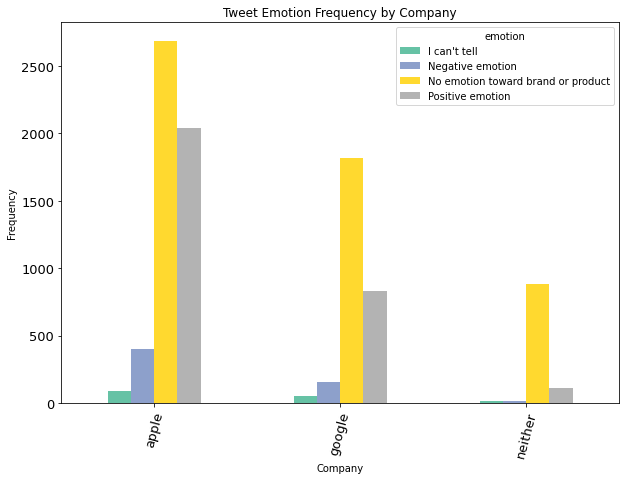

In [329]:
ag_gb.unstack(level = 1).plot(kind = 'bar',
                             figsize = (10,7), 
                             fontsize = 13, 
                             rot = 75,
                             ylabel = 'Frequency',
                             xlabel = 'Company',
                             title = 'Tweet Emotion Frequency by Company',
                             colormap = 'Set2'
                             )

[Text(0.5, 0, 'Company'),
 Text(0, 0.5, 'Relative Frequency'),
 Text(0.5, 1.0, 'Company Mention in Tweet Frequency')]

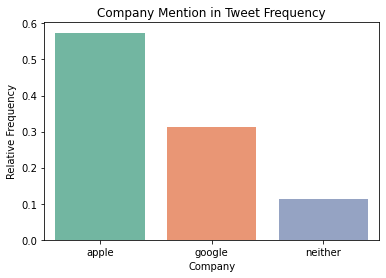

In [330]:
c_freq = sns.barplot(x = df['a_or_g2'].value_counts(normalize = True).index, 
                    y = df['a_or_g2'].value_counts(normalize = True).values,
                    order = ['apple', 'google', 'neither'],
                    palette = 'Set2'
                    )
c_freq.set(xlabel = 'Company', 
           ylabel = 'Relative Frequency',
           title = 'Company Mention in Tweet Frequency'
          )

In [331]:
mean_raw_text_len = df['raw_text_len'].mean()
mean_raw_text_len

104.95106125591114

In [332]:
mean_tokens_linked_len = df['tokens_linked_len'].mean()
mean_tokens_linked_len

76.76641372484329

In [333]:
mean_tokens_list_len = df['tokens_list_len'].mean()
mean_tokens_list_len

12.319146596282854

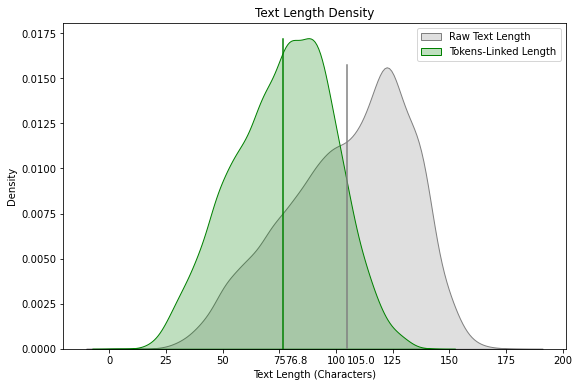

In [334]:
fig, ax = plt.subplots(figsize = (9,6))
sns.kdeplot(df['raw_text_len'], ax = ax, label = 'Raw Text Length', shade = True, color = 'grey')
sns.kdeplot(df['tokens_linked_len'], ax = ax, label = 'Tokens-Linked Length', shade = True, color = 'green')
ax.set(xlabel = 'Text Length (Characters)', title = 'Text Length Density')
ax.axvline(x = mean_raw_text_len, ymax = .87, color = 'grey')
ax.axvline(x = mean_tokens_linked_len, ymax = .95, color = 'green')
ax.text(x = mean_raw_text_len, y = -.0008, s = str(mean_raw_text_len.round(1)))
ax.text(x = mean_tokens_linked_len+1, y = -.0008, s = str(mean_tokens_linked_len.round(1)))
ax.legend()

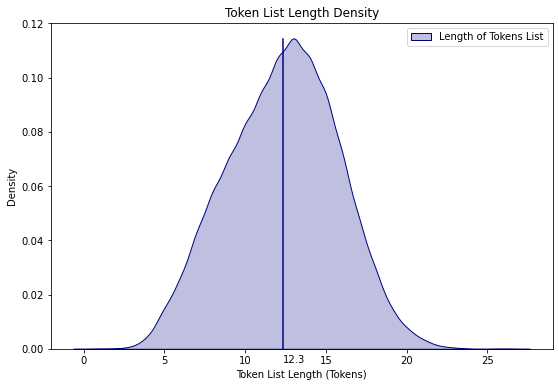

In [335]:
fig, ax = plt.subplots(figsize = (9,6))
sns.kdeplot(df['tokens_list_len'], ax = ax, label = 'Length of Tokens List', shade = True, color = 'navy')
ax.set(xlabel = 'Token List Length (Tokens)', title = 'Token List Length Density')
ax.axvline(x = mean_tokens_list_len, ymax = .95, color = 'navy')
ax.text(x = mean_tokens_list_len, y = -.005, s = str(mean_tokens_list_len.round(1)))
ax.legend()

In [336]:
raw_text_gb = df.groupby('emotion')['raw_text_len'].mean()
raw_text_gb

emotion
I can't tell                          103.980769
Negative emotion                      109.447368
No emotion toward brand or product    104.167749
Positive emotion                      105.558764
Name: raw_text_len, dtype: float64

In [337]:
tok_linked_gb = df.groupby('emotion')['tokens_linked_len'].mean()
tok_linked_gb

emotion
I can't tell                          75.391026
Negative emotion                      78.075439
No emotion toward brand or product    76.827426
Positive emotion                      76.477502
Name: tokens_linked_len, dtype: float64

In [338]:
tok_list_gb = df.groupby('emotion')['tokens_list_len'].mean()
tok_list_gb

emotion
I can't tell                          11.955128
Negative emotion                      12.343860
No emotion toward brand or product    12.291149
Positive emotion                      12.384150
Name: tokens_list_len, dtype: float64

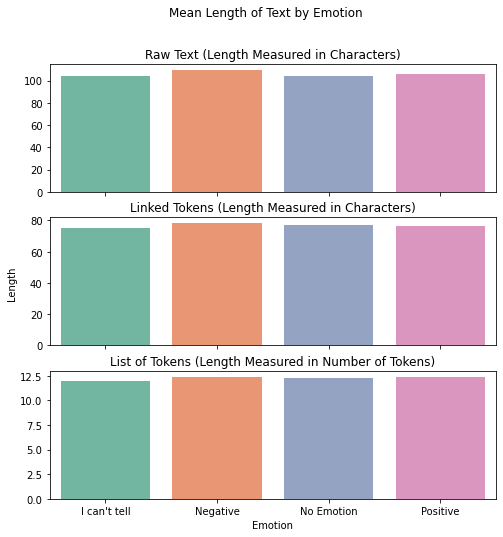

In [423]:
fig, axes = plt.subplots(figsize = (8, 8), nrows= 3, sharex = True, sharey = False)
# fig.subplots_adjust( wspace=0.3)
fig.suptitle('Mean Length of Text by Emotion')
fig.text(0.06, 0.5, 'Length', ha='center', va='center', rotation='vertical')

ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]


sns.barplot(x = raw_text_gb.keys(), y = raw_text_gb.values, ax = ax1, palette = 'Set2')
sns.barplot(x = tok_linked_gb.keys(), y = tok_linked_gb.values, ax = ax2, palette = 'Set2')
sns.barplot(x = tok_list_gb.keys(), y = tok_list_gb.values, ax = ax3, palette = 'Set2')

ax1.title.set_text('Raw Text (Length Measured in Characters)')
ax2.title.set_text('Linked Tokens (Length Measured in Characters)')
ax3.title.set_text('List of Tokens (Length Measured in Number of Tokens)')

ax3.set_xticklabels(["I can't tell", 'Negative', 'No Emotion', 'Positive'])

plt.xlabel('Emotion')

ax1.label_outer()
ax2.label_outer()

## Modeling

In [230]:
df.head()

,text,product,emotion,a_or_g,split_products,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,apple,[iPhone],"[wesley, g, iphone, hrs, tweeting, rise, austi..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,apple,"[iPad, or, iPhone, App]","[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,apple,[iPad],"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,apple,"[iPad, or, iPhone, App]","[sxsw, hope, year's, festival, crashy, year's,..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,google,[Google],"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


In [123]:
data = df['tokens_linked']
target = df['emotion']

In [169]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 0)

In [241]:
total_vocab = set()
for i in data:
    total_vocab.update(i)

In [57]:
vectorizer = TfidfVectorizer()
tf_idf_data_train = vectorizer.fit_transform(X_train)
tf_idf_data_test = vectorizer.transform(X_test)

In [155]:
tf_idf_data = vectorizer.fit_transform(data)

### Naive-Bayes

In [60]:
nb = MultinomialNB()

In [61]:
nb.fit(tf_idf_data_train, y_train)

MultinomialNB()

In [62]:
nb_train_pred = nb.predict(tf_idf_data_train)
nb_test_pred = nb.predict(tf_idf_data_test)

### Support Vector Machine

In [70]:
svm = SVC()

In [71]:
svm.fit(tf_idf_data_train, y_train)

SVC(degree=10)

In [72]:
svm_train_pred = svm.predict(tf_idf_data_train)
svm_test_pred = svm.predict(tf_idf_data_test)

### Random Forest

In [88]:
rfc = RandomForestClassifier(n_estimators = 500, class_weight = 'balanced')

In [89]:
rfc.fit(tf_idf_data_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500)

In [90]:
rfc_train_pred = rfc.predict(tf_idf_data_train)
rfc_test_pred = rfc.predict(tf_idf_data_test)

## Ensemble

In [133]:
ensemble = VotingClassifier(estimators = [('mnb', nb), ('svm', svm), ('rfc', rfc)],
                            voting = 'hard',
                            n_jobs = -1,
                            verbose = True
                           )

In [134]:
ensemble.fit(tf_idf_data_train, y_train)

VotingClassifier(estimators=[('mnb', MultinomialNB()), ('svm', SVC(degree=10)),
                             ('rfc',
                              RandomForestClassifier(class_weight='balanced',
                                                     n_estimators=500))],
                 n_jobs=-1, verbose=True)

In [135]:
ensemble_train_pred = ensemble.predict(tf_idf_data_train)
ensemble_test_pred = ensemble.predict(tf_idf_data_test)

In [156]:
cv = cross_validate(estimator = ensemble, 
                    X = tf_idf_data, 
                    y = target,
                    scoring = 'f1_weighted',
                    n_jobs = -1,
                    verbose = True
                   )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


## Model Evalutation

In [65]:
print('NB train', accuracy_score(y_train, nb_train_pred))
print('NB test', accuracy_score(y_test, nb_test_pred))

NB train 0.7416043408124359
NB test 0.6341248900615655


In [82]:
print('SVM train', accuracy_score(y_train, svm_train_pred))
print('SVM test', accuracy_score(y_test, svm_test_pred))

SVM train 0.8926528816542015
SVM test 0.6666666666666666


In [91]:
print('RFC train', accuracy_score(y_train, rfc_train_pred))
print('RFC test', accuracy_score(y_test, rfc_test_pred))

RFC train 0.9941340372488635
RFC test 0.6451187335092349


In [168]:
print('Ensemble train F1', f1_score(y_train, ensemble_train_pred, average = 'weighted'))
print('Ensemble test F1', f1_score(y_test, ensemble_test_pred, average = 'weighted'))

Ensemble train F1 0.8948833420228234
Ensemble test F1 0.6184921072581573


In [162]:
print('Cross Validation F1 score:',cv['test_score'].mean())

Cross Validation F1 score: 0.6334824699516154
